# Step 2: Determine crossing and angle for each cuscuta coil

- Limiting ourselves to only once cuscuta of only one image at a time
- At the end, we put everything into a function that we later export to the next step

In [1]:
from glob import glob
import cv2
import numpy as np
import itertools as it
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Polygon, Wedge
import tifffile as tf

from scipy import ndimage, signal, spatial
from skimage import morphology

import os
import pandas as pd

from importlib import reload

from sklearn import linear_model, cluster

In [2]:
colors = [None, '#117733', '#aa4499', '#332288', '#ddcc77', '#88ccee', '#44aa99']
buffx = 0
buffX = 1475
buffy = 200
buffz = 50

nsamples = 5

isrc = '../raw/'
rsrc = '../reference/'
ssrc = '../proc/skel/'
time = '4pm'
rep = 7

meta = pd.read_csv(rsrc + 'reference_positions_{}_rep{}.csv'.format(time, rep))
meta = meta.set_index('numidx')
meta.head()

,peaks_0,peaks_1,peaks_2,peaks_3,peaks_4,tapes_0,tapes_1,tapes_2,tapes_3,tapes_4,coef0_0,coef0_1,coef0_2,coef0_3,coef0_4,coef1_0,coef1_1,coef1_2,coef1_3,coef1_4
numidx,,,,,,,,,,,,,,,,,,,,
1,617,1307,2081,2945,3787,903,992,995,1194,1395,224.909,228.658,190.235,183.072,189.759,-0.017661,-0.021867,0.001748,0.014864,0.009036
2,597,1291,2069,2931,3769,893,980,983,1181,1412,227.745,200.906,186.711,181.974,192.363,-0.017171,0.005466,0.004167,0.015038,0.008791
3,573,1296,2061,2927,3762,903,991,993,1221,1447,236.140,188.049,187.639,183.790,190.927,-0.007194,0.008313,0.003852,0.011888,0.011083
4,583,1296,2064,2930,3766,890,978,979,1174,1402,232.565,181.112,185.558,180.871,187.369,-0.011769,0.015637,0.003632,0.012464,0.010194
5,604,1297,2065,2925,3761,891,976,979,1176,1428,218.414,201.373,184.803,182.785,189.889,-0.017212,-0.003465,0.003809,0.014073,0.009635


# Get the same metadata as in the previous steps

- Also compute the direction vectors `v` for each skewer
- The respective normal vectors `n`
- This will help us with linear algebra below

In [44]:
idx = 400
tapes = meta.loc[idx, ['tapes_{}'.format(i) for i in range(nsamples)]].values.astype(int)
peaks = meta.loc[idx, ['peaks_{}'.format(i) for i in range(nsamples)]].values.astype(int)
peaks = np.hstack((peaks, peaks[-1] + np.max(np.ediff1d(peaks)) ))

coefs = meta.loc[idx, ['coef0_{}'.format(i) for i in range(nsamples)] + ['coef1_{}'.format(i) for i in range(nsamples)] ].values
coefs = np.reshape(coefs, (nsamples, 2), order='F')

xvals = np.arange(buffX)
lines = np.zeros((nsamples, buffX))

v = np.column_stack([coefs[:,1], np.ones(len(coefs))])
v /= np.linalg.norm(v, axis=1).reshape(-1,1)
n = np.column_stack((v[:,1], -v[:,0]))

for i in range(len(lines)):
    b0 = peaks[i] + coefs[i,0] - buffy
    lines[i] = b0 + coefs[i,1]*(xvals - buffx)

plants = [ np.s_[buffx:tapes[0]+buffx, 0:peaks[1]-buffz] ]

for i in range(1,len(tapes)):
    plants.append(np.s_[buffx:tapes[i]+buffx, peaks[i-1]+buffz:peaks[i+1]-buffz])

# Determine crossings and angles

- Fix a specific skewer `pidx`
- Get the corresponding subimage and skeleton as in last notebook
- Get the specific linear algebra values of the skewer line in the subimage
- Consider the distance of every skeleton pixel to the skewer
- Define a crossing as instances when skeleton's distance to skewer is less than 20
- Use DBSCAN to distinguish coils if necessary
- The crossing point is defined as the cluster's point closest to the skewer
- If there are more than 2 clusters, check if one coil is being double counted
- Merge clusters if their crossing points are less than 35px apart
- Approximate the coil with RANSAC regression, as there could be skewer/stem noise

![](https://raw.githubusercontent.com/ejamezquita/ejamezquita.github.io/main/cuscuta/figs/skeleton_labeling.svg)

In [45]:
pidx = 0
xlen = xvals[ plants[pidx][0] ] - plants[pidx][0].start
line = lines[ pidx, plants[pidx][0] ] - plants[pidx][1].start
b = n[pidx,0] * line[0]
filename = ssrc + '{}_rep{}/plant_{:02d}/{}_rep{}_p{:02d}_{:04d}.csv'.format(time, rep, pidx, time, rep, pidx, idx)
skeleton = np.loadtxt(filename, dtype=int, delimiter=',')

In [46]:
dist = np.abs(skeleton[1]*n[pidx, 0] + skeleton[0]*n[pidx, 1] - b)
print('Min dist: {:.2f}\nMax dist: {:.2f}'.format(np.min(dist),np.max(dist)))
dmask = dist < 15
mmask = dist < 25

print('Number of pixels close to center:\t', np.sum(dmask))
if np.sum(dmask) > 5:
    clustering = cluster.DBSCAN(eps=10, min_samples=5)
    clusts = clustering.fit_predict(skeleton[:, dmask].T, sample_weight=100-dist[dmask])
    uq = np.unique(clusts[clusts >= 0])
    
    print('DBSCAN clusters:\t', uq)

Min dist: 0.40
Max dist: 101.57
Number of pixels close to center:	 37
DBSCAN clusters:	 [0]


In [47]:
seeds = np.zeros((len(uq), len(skeleton)), dtype=int)
for i in range(len(uq)):
    foo = np.argmin(dist[dmask][clusts==uq[i]])
    seeds[i] = skeleton[:,dmask][:, clusts==uq[i] ][:, foo]
    
dm = np.triu(spatial.distance.squareform(spatial.distance.pdist(seeds)))
dm[dm == 0] = 100
merge = np.asarray(np.nonzero(dm < 35))
if merge.shape[1] > 0:
    for i in range(len(merge[0])):
        clusts[clusts == merge[1,i]] = merge[0,i]
uq = np.unique(clusts[clusts >= 0])

dm = spatial.distance.cdist(skeleton[:, dmask].T, skeleton[:, mmask].T)
nclusts = clusts[np.argmin(dm, axis=0)]

In [50]:
lcoefs = np.zeros((len(uq), 2))
angle = np.zeros(len(uq))

for i in range(len(uq)):
    y,X = skeleton[:, mmask][:, nclusts == uq[i]]
    ransac = linear_model.RANSACRegressor(random_state=42, min_samples=5)
    reg = ransac.fit(X.reshape(-1,1), y, (np.max(dist) - dist[mmask][nclusts==uq[i]])**4)
    
    coef1 = np.diff(reg.predict([[0],[1]]))[0]
    coef0 = reg.predict([[0]])[0]
    
    w = np.array([1, coef1])
    w /= np.linalg.norm(w)
    
    lcoefs[i] = [coef0, coef1]
    angle[i] = -np.sign(coef1)*np.arccos(np.abs(np.sum(w*n[pidx])))
print(seeds[uq], np.rad2deg(angle), sep='\n')

[[350 608]]
[49.98459548]


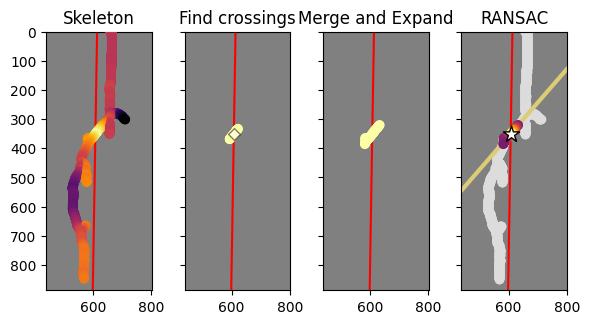

In [49]:
fig, ax = plt.subplots(1,4,figsize=(6,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].scatter(skeleton[1], skeleton[0], c=dist, cmap='inferno_r', vmin=0, zorder=3)

ax[1].scatter(skeleton[1, dmask], skeleton[0, dmask], c=clusts, cmap='inferno_r', zorder=3)
ax[1].scatter(seeds[:,1], seeds[:,0], marker='D', c='white', edgecolor='k', alpha=0.5, zorder=4)

ax[2].scatter(skeleton[1, mmask], skeleton[0, mmask], c=nclusts, cmap='inferno_r', zorder=3)

ax[3].scatter(skeleton[1,~mmask], skeleton[0,~mmask], c='gainsboro',zorder=1)
ax[3].scatter(skeleton[1,mmask], skeleton[0,mmask], c=(np.max(dist) - dist[mmask])**4, cmap='inferno', vmin=0, zorder=3)
for i in range(len(uq)):
    xy1 = (line[seeds[uq[i],0]], seeds[uq[i],0])
    ax[3].axline(xy1, slope=lcoefs[i,1], c=colors[i+4], lw = 3, zorder=2)
    ax[3].scatter(*xy1, c='w', s=150, marker='*', zorder=4, edgecolor='k', linewidths=1)

for i in range(len(ax)):
    ax[i].plot(line, xlen, c='r', zorder=1)
    ax[i].set_aspect('equal')
    ax[i].margins(x=0.5, y=0)
    ax[i].set_facecolor('gray')
ax[0].invert_yaxis()

ax[0].set_title('Skeleton')
ax[1].set_title('Find crossings')
ax[2].set_title('Merge and Expand')
ax[3].set_title('RANSAC')

fig.tight_layout();
#plt.savefig('skeleton_labeling.svg', format='svg', bbox_inches='tight')

# Scratch

In [33]:
img1 = tf.imread(filenames[anums[idx]])//40
img1[img1 > 2] = 0
scalebar = len(img1) - np.asarray([20, 20 + 28*2])
#img1[img1 > 1] = 2

#plt.imshow(img1)

In [34]:
C = np.array([np.array([137, 685, 400, 666]),
              np.array([329, 733, 528, 742]),
              np.array([419, 976, 603, 818]),
              np.array([ 342,  945,  710, 1009]),
              np.array([474, 962, 735, 857])])
w = (C[:,3] - C[:,2])
h = (C[:,1] - C[:,0])
W = int(np.max(w/h)*h[pidx]) - w[pidx]
ww = W//2
ww

40

../proc/plots/4pm_rep7_plant2_v08_0448


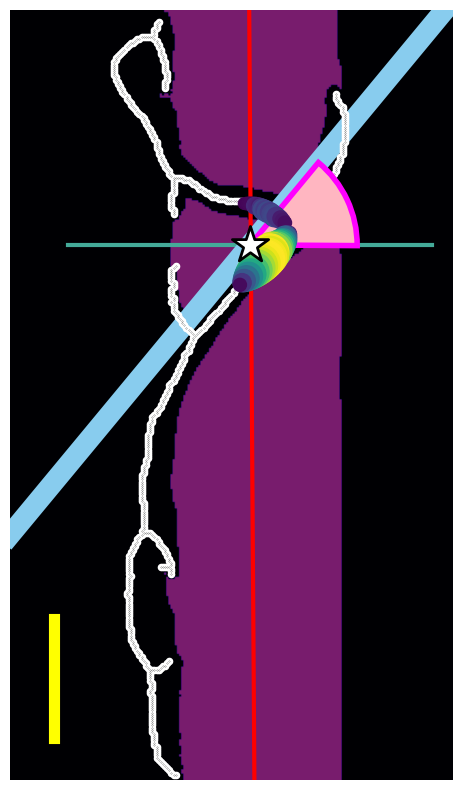

In [35]:
colors = [None, '#117733', '#aa4499', '#332288', '#ddcc77', '#88ccee', '#44aa99']

fig, ax = plt.subplots(1,1,figsize=(6,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(np.pad(img1, ((0,0), (ww,ww))), cmap='inferno', vmin=0, vmax=3, zorder = 1, origin='upper');

for i in range(len(coms)):
    i = -i - 1 
    xy1 = (coms[i,1]+ww, coms[i,0])
    xy2 = np.array([xy1[0]-85, xy1[0]+85])
    grad = (dcom[i]/np.max(dcom[i]))

    #ax[0].axline(xy1, slope = ll[idx][1]-ll[idx][0], c='yellow', alpha=1, lw=2, ls='-.', zorder=3)
    ax[0].plot([xy1[0]-85, xy1[0]+85], [xy1[1], xy1[1]], c=colors[6], alpha=1, lw=3, ls='-', zorder=3)
    ax[0].axline(xy1, slope = coefs[i,1], c=colors[6+i], alpha=1, lw=15, zorder=4)
    
    ax[0].scatter(cross[1, dmask[i]]+ww, cross[0, dmask[i]], 
                  c=dcom[i], alpha=1, marker='o', cmap='viridis', s=750*grad, zorder=10)
    
    ax[0].scatter(*xy1, c='w', s=750, marker='*', zorder=15, edgecolor='k', linewidths=2)
    wedges = Wedge(xy1, 50, np.rad2deg(np.arctan(coefs[i,1])), 
                   np.rad2deg(np.arctan(ll[idx][1]-ll[idx][0])),
                   #width = 5,
                   facecolor='lightpink', edgecolor='fuchsia', lw=4, alpha=1, zorder=9) 
    ax[0].add_patch(wedges)

ax[0].plot([20,20], scalebar, c='yellow', lw=8, zorder=11)
ax[0].scatter(scoords[1]+ww, scoords[0], c='w', marker='o', zorder=6, s=20, alpha=1)
ax[0].scatter(scoords[1]+ww, scoords[0], c='k', marker='.', zorder=6, s=0.1, alpha=1)
ax[0].plot(ll[idx]+ww,xx[idx], color='red', lw=3, zorder=2);
ax[0].axis('off')
ax[0].margins(0)

fig.tight_layout()

filename = '{}{}_rep{}_plant{}_v08_{:04d}'.format(dst,time,rep,pidx,nums[anums[idx]])
print(filename)
plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')

In [20]:
img0 = tf.imread(filenames[anums[idx]])
img1 = tf.imread(filenames[anums[idx]])//40
img1[img1 > 1] = 2
img1[img0 > 160] += 2

../proc/plots/4pm_rep7_plant2_v06_0330


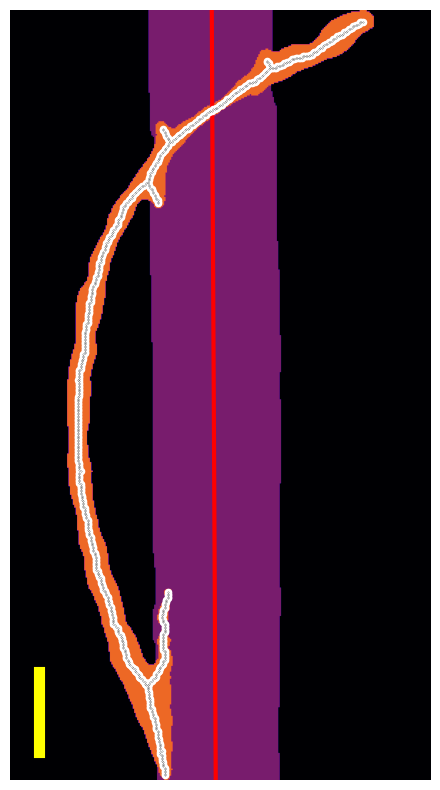

In [21]:
colors = [None, '#117733', '#aa4499', '#332288', '#ddcc77', '#88ccee', '#44aa99']

fig, ax = plt.subplots(1,1,figsize=(6,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(np.pad(img1, ((0,0), (ww,ww))), cmap='inferno', vmin=0, vmax = 3, zorder = 1, origin='upper');

ax[0].plot([20,20], scalebar, c='yellow', lw=8, zorder=11)
ax[0].scatter(scoords[1]+ww, scoords[0], c='w', marker='o', zorder=6, s=20, alpha=1)
ax[0].scatter(scoords[1]+ww, scoords[0], c='k', marker='.', zorder=6, s=0.1, alpha=1)
ax[0].plot(ll[idx]+ww,xx[idx], color='red', lw=3, zorder=2);
ax[0].axis('off')
ax[0].margins(0)

fig.tight_layout()

filename = '{}{}_rep{}_plant{}_v06_{:04d}'.format(dst,time,rep,pidx,nums[anums[idx]])
print(filename)
plt.savefig(filename + '.jpg', format='jpg', dpi=200, pil_kwargs={'optimize':True}, bbox_inches='tight')